In [89]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [90]:
import numpy as np
import pandas as pd

In [91]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [92]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [93]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [94]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [95]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [96]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [97]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [98]:
inspector = inspect(engine)

inspector.get_table_names()

stationcolumns = inspector.get_columns('station')
measurementcolumns = inspector.get_columns('measurement')


In [99]:
for c in stationcolumns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [100]:
for c in measurementcolumns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [101]:
#dt.datetime.today().strftime('%Y-%m-%d')

# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [102]:
enddate = str(session.query(Measurement.date).order_by(Measurement.date.desc()).first())

In [103]:
enddate

"('2017-08-23',)"

In [104]:
#Note: I know there is a better way to input this date into the dt.date() formula, but I went for the easy way here. Also,
#2016 was a leap year, but 2017 was not, so the 365 is correct here. 



# Calculate the date 1 year ago from the last data point in the database


query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


In [105]:
#My original code did not include the order_by, but I have noticed that the months of november and december 
#were not properly arranged. 
#I ordered the session so that these work.

# Perform a query to retrieve the data and precipitation scores

recentyear = session.query(Measurement.date, Measurement.prcp).order_by(Measurement.date.desc()).\
    filter(Measurement.date > query_date).all()

In [106]:
recentyear[-1]

('2016-08-24', 1.45)

In [107]:
recentdate = []
recentprcp = []

for i in recentyear:
    x, y = i
    recentdate.append(dt.datetime.strptime(x, '%Y-%m-%d')), recentprcp.append(y)
    
    


In [111]:

# Save the query results as a Pandas DataFrame and set the index to the date column
type(recentdate[1])

recentdf = pd.DataFrame(recentyear)

In [112]:
recentdf = recentdf.set_index(recentdf['date'])
recent2df = pd.DataFrame(recentdf['prcp'])

In [113]:
recent2df = recent2df.sort_index(axis = 0, ascending = True)

Text(0,0.5,'Precipitation in inches')

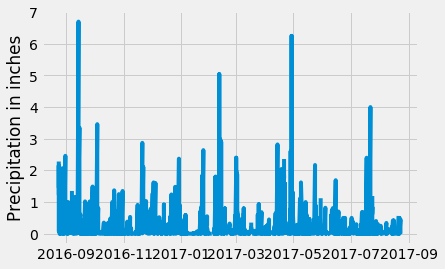

In [114]:
# Sort the dataframe by date
#Note: This dataframe appears to be already sorted by date, because of the way I called the session query. 
#The date does go in reverse chronological order, however. 
#However, I have done it here for completion. 

# Use Pandas Plotting with Matplotlib to plot the data

#Below was the original way I did this, which required less coding. It does not use a dataframe, just two lists. 

fig, ax = plt.subplots()
plt.plot(recentdate, recentprcp)
plt.ylabel("Precipitation in inches")

#This way is better, because it requires less code, is sorted properly, and does not require explicit changes to the x-axis.


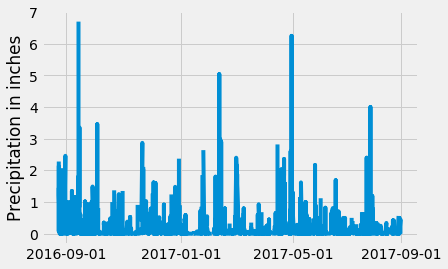

In [115]:

#I also did the following way, for completion's sake
fig, ax = plt.subplots()
plt.plot(recent2df.index.values, recent2df['prcp'])
plt.ylabel("Precipitation in inches")
plt.xticks(['2016-09-01', '2017-01-01', '2017-05-01', '2017-09-01'])

#Note: The x-tick placement is kind of arbitary, just did what looked good. 

plt.show()

In [116]:
# Use Pandas to calcualte the summary statistics for the precipitation data

#Here it makes sense why it is in a dataframe:

recent2df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [117]:
# Design a query to show how many stations are available in this dataset?
len(session.query(func.count(Measurement.station)).group_by(Measurement.station).all())


9

In [118]:
#This might be easier to understand by going one step down:

session.query(func.count(Measurement.station)).group_by(Measurement.station).all()

#This gives a list with the number of observations at each station. We use len() to count the number of stations.


[(1979), (2709), (2202), (2612), (1372), (511), (2772), (2724), (2669)]

In [119]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()


#Same as above, but returning a tuple with the station name. 


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [120]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs),\
func.avg(Measurement.tobs), func.count(Measurement.station)).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()


#In the respective order asked for:

[('USC00519281', 54.0, 85.0, 71.66378066378067, 2772),
 ('USC00519397', 56.0, 87.0, 74.55323054331865, 2724),
 ('USC00513117', 59.0, 85.0, 72.68918420081211, 2709),
 ('USC00519523', 56.0, 85.0, 74.5436493068565, 2669),
 ('USC00516128', 58.0, 84.0, 70.91500765696784, 2612),
 ('USC00514830', 58.0, 85.0, 74.8732970027248, 2202),
 ('USC00511918', 53.0, 87.0, 71.61596766043456, 1979),
 ('USC00517948', 58.0, 87.0, 74.68440233236151, 1372),
 ('USC00518838', 58.0, 83.0, 72.72407045009784, 511)]

Text(0.5,0,'Temperature')

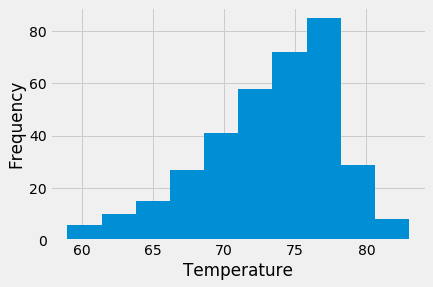

In [121]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#session.query(Measurement.station == 'USC00519281', Measurement.tobs)



tempdf = pd.DataFrame(session.query(Measurement.date, Measurement.tobs).order_by(Measurement.date.desc()).\
    filter(Measurement.date > query_date).filter(Measurement.station == 'USC00519281').all())

fig, ax = plt.subplots()
plt.hist(tempdf['tobs'])
plt.ylabel("Frequency")
plt.xlabel("Temperature")



In [122]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [31]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [32]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [33]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [34]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [35]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [36]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [37]:
# Plot the daily normals as an area plot with `stacked=False`
